In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 24s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_point1.csv', index_col=[0])
print(shap_summary_df.shape)
shap_summary_df.head()

(123, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.485132,93.316415,93.211705,93.266883,91.278743,92.911776
공시지가(만원),76.387461,81.845653,78.676910,76.717127,79.230949,78.571620
year_linear,62.542850,63.358196,64.053425,63.834981,63.227332,63.403357
건축년도,50.790124,48.005067,46.078070,50.592085,48.346418,48.762353
전용면적,44.501021,38.678137,38.713083,41.736588,37.490192,40.223804


In [13]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [14]:
shap_summary_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.485132,93.316415,93.211705,93.266883,91.278743,92.911776
공시지가(만원),76.387461,81.845653,78.676910,76.717127,79.230949,78.571620
year_linear,62.542850,63.358196,64.053425,63.834981,63.227332,63.403357
건축년도,50.790124,48.005067,46.078070,50.592085,48.346418,48.762353
전용면적,44.501021,38.678137,38.713083,41.736588,37.490192,40.223804


In [15]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
제1종일반주거지역,0.284200,0.369891,0.307517,0.358262,0.299991,0.323972
중로2류(폭_15M~20M),0.354911,0.291750,0.284473,0.372161,0.265914,0.313842
가로구역별_최고높이_제한지역,0.344322,0.292314,0.287480,0.281233,0.309441,0.302958
비행안전제2구역(전술),0.264543,0.324281,0.313311,0.289814,0.240594,0.286508
완충녹지,0.260610,0.256908,0.325770,0.254481,0.305130,0.280580
용도구역기타,0.194055,0.257354,0.335589,0.333398,0.260128,0.276104
자연녹지지역,0.226644,0.257803,0.320219,0.388006,0.186153,0.275765
상수원보호기타,0.276557,0.226273,0.353046,0.243519,0.256310,0.271141
대로3류(폭_25M~30M),0.240874,0.219547,0.192390,0.246953,0.307662,0.241485
수평표면구역,0.206343,0.260148,0.210457,0.249841,0.256986,0.236755


In [16]:
top_50_df = shap_summary_df.iloc[:50,:]
print(top_50_df.shape)

(50, 6)


In [17]:
top_50_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.485132,93.316415,93.211705,93.266883,91.278743,92.911776
공시지가(만원),76.387461,81.845653,78.676910,76.717127,79.230949,78.571620
year_linear,62.542850,63.358196,64.053425,63.834981,63.227332,63.403357
건축년도,50.790124,48.005067,46.078070,50.592085,48.346418,48.762353
전용면적,44.501021,38.678137,38.713083,41.736588,37.490192,40.223804


In [18]:
top_50_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
지형높이,2.296308,1.865032,2.154391,2.313798,2.378543,2.201614
층min,1.903951,2.063733,2.314142,1.993556,2.284559,2.111988
부속건축물면적,2.144640,2.093598,1.878060,1.857956,2.584737,2.111798
옥외자주식대수,1.869852,1.919489,1.737835,1.694161,1.895644,1.823396
(한강)폐기물매립시설_설치제한지역,1.854121,1.930315,1.662507,1.810152,1.536125,1.758644
지형형상,1.331630,1.320171,1.216086,1.307716,1.198695,1.274860
부속건축물수,0.896491,1.080250,1.032418,1.345171,1.918133,1.254493
y_sin,1.051328,0.968767,1.072812,1.137464,1.061332,1.058341
x_sin,1.124503,0.982541,0.936018,1.133716,1.058121,1.046980
상대정화구역,0.931580,1.023097,1.087555,1.044556,0.921205,1.001599


In [19]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [20]:
training_data_df = training_data_df[top_50_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 55)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,토지이동상황,총건축면적,옥내자주식대수,아파트지구,호수대비부속건축물면적,호수대비연면적,xnorm,총호수,층,호수대비주차수,y_2nd,용도지역명1,층norm,지구단위계획구역,도로접면,가축사육제한구역,month_sin,건물나이,지붕_평지붕_fraction,공원,지형높이,층min,부속건축물면적,옥외자주식대수,(한강)폐기물매립시설_설치제한지역,지형형상,부속건축물수,y_sin,x_sin,상대정화구역,y_cos,x_cos,중점경관관리구역,옥내기계식대수,장애물제한표면구역,제1종지구단위계획구역,제2종일반주거지역,제3종일반주거지역,총외필지수,정비구역,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,0,0.0,98.537963,5579.095707,54.0,2,0.0,4.094180e+07,0,0.222222,0,0,0,-0.866025,0,1.0,0,0,9.0,0.0,0.0,0,0,0.0,-0.920469,-0.364267,0,0.390815,0.931294,0,0.0,0,0,0,0,1.0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,0,0.0,98.537963,5579.095707,54.0,2,0.0,4.094180e+07,0,0.222222,0,0,0,-0.500000,0,1.0,0,0,9.0,0.0,0.0,0,0,0.0,-0.920469,-0.364267,0,0.390815,0.931294,0,0.0,0,0,0,0,1.0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,0,0.0,98.537963,5579.095707,54.0,4,0.0,4.094180e+07,0,0.444444,0,0,0,0.000000,0,1.0,0,0,9.0,0.0,0.0,0,0,0.0,-0.920469,-0.364267,0,0.390815,0.931294,0,0.0,0,0,0,0,1.0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,0,0.0,98.537963,5579.095707,54.0,9,0.0,4.094180e+07,0,1.000000,0,0,0,0.866025,0,1.0,0,0,9.0,0.0,0.0,0,0,0.0,-0.920469,-0.364267,0,0.390815,0.931294,0,0.0,0,0,0,0,1.0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,0,0.0,98.537963,5579.095707,54.0,1,0.0,4.094180e+07,0,0.111111,0,0,0,-0.866025,0,1.0,0,0,9.0,0.0,0.0,0,0,0.0,-0.920469,-0.364267,0,0.390815,0.931294,0,0.0,0,0,0,0,1.0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [21]:
from sklearn.model_selection import KFold, GroupKFold

In [22]:
import lightgbm as lgb

In [23]:
from sklearn.metrics import r2_score

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

19

In [26]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 50)
y dist plot


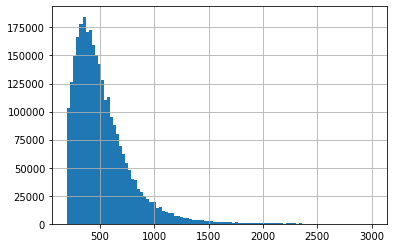

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6139
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5819
[100]	valid_0's huber: 64.8789
[150]	valid_0's huber: 58.7769
[200]	valid_0's huber: 55.1058
[250]	valid_0's huber: 52.4581
[300]	valid_0's huber: 50.6784
[350]	valid_0's huber: 49.2944
[400]	valid_0's huber: 48.2432
[450]	valid_0's huber: 47.2969
[500]	valid_0's huber: 46.6175
[550]	valid_0's huber: 45.8531
[600]	valid_0's huber: 45.232
[650]	valid_0's huber: 44.6554
[700]	valid_0's huber: 44.1202
[750]	valid_0's huber: 43.6706
[800]	valid_0's huber: 43.2224
[850]	valid_0's huber: 42.8057
[900]	valid_0's huber: 42.4314
[950]	valid_0's huber: 42.0911
[1000]	valid_0's huber: 41.7506
[1050]	valid_0's huber: 41.4526
[1100]	valid_0's huber: 41.1211
[1150]	valid_0's huber: 40.8693
[1200]	valid_0's huber: 40.6114
[1250]	valid_0's huber: 40.3689
[1300]	valid_0's huber: 40.1311
[1350]	valid_0's huber: 39.9405
[1400]	valid_0's huber: 39.752
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


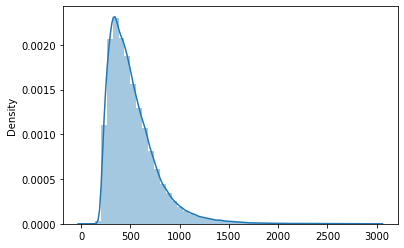

Fold 0 end
Fold 1 start
(2926581, 50)
y dist plot


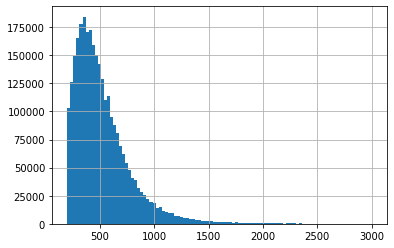

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6137
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6868
[100]	valid_0's huber: 65.0106
[150]	valid_0's huber: 58.7317
[200]	valid_0's huber: 55.0288
[250]	valid_0's huber: 52.5907
[300]	valid_0's huber: 50.8286
[350]	valid_0's huber: 49.4307
[400]	valid_0's huber: 48.3497
[450]	valid_0's huber: 47.4123
[500]	valid_0's huber: 46.6742
[550]	valid_0's huber: 45.8696
[600]	valid_0's huber: 45.1516
[650]	valid_0's huber: 44.6061
[700]	valid_0's huber: 44.0744
[750]	valid_0's huber: 43.5862
[800]	valid_0's huber: 43.141
[850]	valid_0's huber: 42.7609
[900]	valid_0's huber: 42.3717
[950]	valid_0's huber: 41.9774
[1000]	valid_0's huber: 41.6459
[1050]	valid_0's huber: 41.3813
[1100]	valid_0's huber: 41.088
[1150]	valid_0's huber: 40.8084
[1200]	valid_0's huber: 40.5272
[1250]	valid_0's huber: 40.2867
[1300]	valid_0's huber: 40.0963
[1350]	valid_0's huber: 39.8676
[1400]	valid_0's huber: 39.6509
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


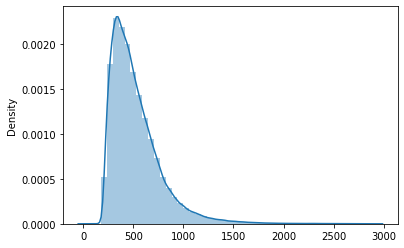

Fold 1 end
Fold 2 start
(2926581, 50)
y dist plot


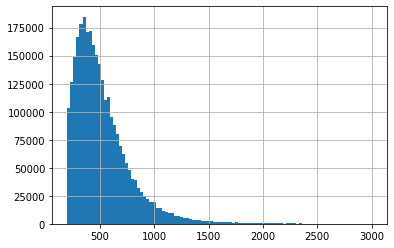

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6140
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.481
[100]	valid_0's huber: 64.5859
[150]	valid_0's huber: 58.5664
[200]	valid_0's huber: 54.7988
[250]	valid_0's huber: 52.5198
[300]	valid_0's huber: 50.8845
[350]	valid_0's huber: 49.435
[400]	valid_0's huber: 48.3369
[450]	valid_0's huber: 47.3972
[500]	valid_0's huber: 46.6621
[550]	valid_0's huber: 45.9705
[600]	valid_0's huber: 45.2618
[650]	valid_0's huber: 44.6751
[700]	valid_0's huber: 44.181
[750]	valid_0's huber: 43.6958
[800]	valid_0's huber: 43.2733
[850]	valid_0's huber: 42.8527
[900]	valid_0's huber: 42.4764
[950]	valid_0's huber: 42.1356
[1000]	valid_0's huber: 41.8025
[1050]	valid_0's huber: 41.487
[1100]	valid_0's huber: 41.1879
[1150]	valid_0's huber: 40.8959
[1200]	valid_0's huber: 40.6294
[1250]	valid_0's huber: 40.4299
[1300]	valid_0's huber: 40.1922
[1350]	valid_0's huber: 40.0041
[1400]	valid_0's huber: 39.8142
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


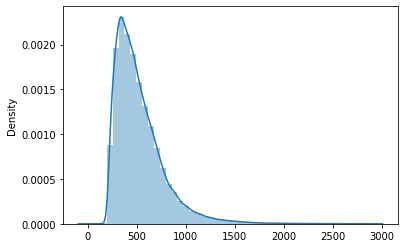

Fold 2 end
Fold 3 start
(2926581, 50)
y dist plot


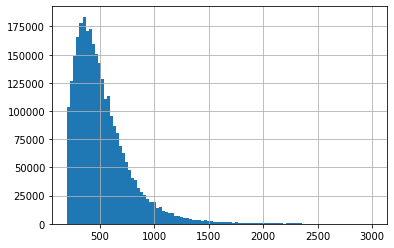

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6134
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5235
[100]	valid_0's huber: 64.7379
[150]	valid_0's huber: 58.7284
[200]	valid_0's huber: 55.0477
[250]	valid_0's huber: 52.4705
[300]	valid_0's huber: 50.7822
[350]	valid_0's huber: 49.4628
[400]	valid_0's huber: 48.2562
[450]	valid_0's huber: 47.3671
[500]	valid_0's huber: 46.5662
[550]	valid_0's huber: 45.8262
[600]	valid_0's huber: 45.2339
[650]	valid_0's huber: 44.5928
[700]	valid_0's huber: 44.0354
[750]	valid_0's huber: 43.5301
[800]	valid_0's huber: 43.1021
[850]	valid_0's huber: 42.7296
[900]	valid_0's huber: 42.3912
[950]	valid_0's huber: 42.083
[1000]	valid_0's huber: 41.7629
[1050]	valid_0's huber: 41.4674
[1100]	valid_0's huber: 41.2152
[1150]	valid_0's huber: 40.9717
[1200]	valid_0's huber: 40.7153
[1250]	valid_0's huber: 40.4961
[1300]	valid_0's huber: 40.2621
[1350]	valid_0's huber: 40.0628
[1400]	valid_0's huber: 39.8783
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


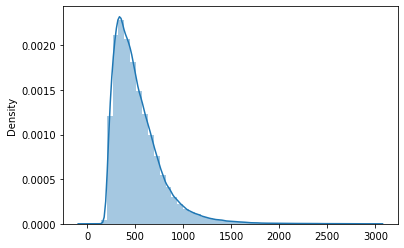

Fold 3 end
Fold 4 start
(2926581, 50)
y dist plot


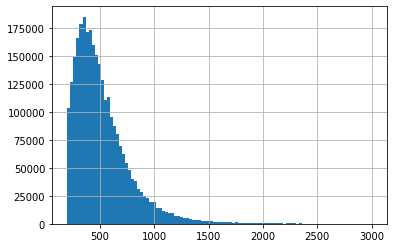

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6134
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4209
[100]	valid_0's huber: 64.6336
[150]	valid_0's huber: 58.6688
[200]	valid_0's huber: 55.1946
[250]	valid_0's huber: 52.6506
[300]	valid_0's huber: 50.8296
[350]	valid_0's huber: 49.4486
[400]	valid_0's huber: 48.3466
[450]	valid_0's huber: 47.5759
[500]	valid_0's huber: 46.8223
[550]	valid_0's huber: 45.9409
[600]	valid_0's huber: 45.2908
[650]	valid_0's huber: 44.6688
[700]	valid_0's huber: 44.1519
[750]	valid_0's huber: 43.6782
[800]	valid_0's huber: 43.2642
[850]	valid_0's huber: 42.8235
[900]	valid_0's huber: 42.4127
[950]	valid_0's huber: 42.0682
[1000]	valid_0's huber: 41.7506
[1050]	valid_0's huber: 41.4495
[1100]	valid_0's huber: 41.1686
[1150]	valid_0's huber: 40.8921
[1200]	valid_0's huber: 40.6127
[1250]	valid_0's huber: 40.3864
[1300]	valid_0's huber: 40.1721
[1350]	valid_0's huber: 39.9693
[1400]	valid_0's huber: 39.7874
[1450]	

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


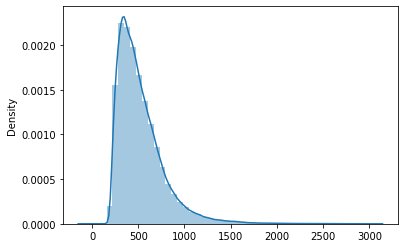

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [27]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_50_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[x_val.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

64.80893518641601

In [30]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [31]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [32]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [33]:
shap_summary_df.index = x_train.columns

In [34]:
shap_summary_df.to_csv(basedir + 'shap_top_50.csv')

In [35]:
#